# Confidence Intervals


Confidence intervals are one of the main tools of inferential statistics.  They are used to convey the precision of available information about a quantitative population parameter (the true value of which is unknown).  A confidence interval has a stated *coverage probability* that is usually set to 0.95 by convention.  The confidence interval is random (it changes with every sample of data), and a 95% confidence interval has 95% probability of containing the true value of the population parameter.  Another way of thinking about this is that the confidence interval contains all values of the unknown population parameter that are compatible with the data.

This tutorial demonstrates how to construct confidence intervals for the difference between two population proportions, and for the difference between two population means.  These are two of the most common settings where confidence intervals arise.

We will use the 2015-2016 wave of the NHANES data for our analysis.

To illustrate comparison of population proportions, we will analyze the difference between the proportion of females who smoke, and the proportion of males who smoke.  The column that specifies smoker and non-smoker is "SMQ020" in our dataset.

To illustrate comparison of population means, we will analyze the difference between mean body mass index (BMI) for females and for males.  The column that has the body mass index values is "BMXBMI".

Additionally, the gender is specified in the column "RIAGENDR".

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
da = pd.read_csv("nhanes_2015_2016.csv")

In [3]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5735 non-null   int64  
 1   ALQ101    5208 non-null   float64
 2   ALQ110    1731 non-null   float64
 3   ALQ130    3379 non-null   float64
 4   SMQ020    5735 non-null   int64  
 5   RIAGENDR  5735 non-null   int64  
 6   RIDAGEYR  5735 non-null   int64  
 7   RIDRETH1  5735 non-null   int64  
 8   DMDCITZN  5734 non-null   float64
 9   DMDEDUC2  5474 non-null   float64
 10  DMDMARTL  5474 non-null   float64
 11  DMDHHSIZ  5735 non-null   int64  
 12  WTINT2YR  5735 non-null   float64
 13  SDMVPSU   5735 non-null   int64  
 14  SDMVSTRA  5735 non-null   int64  
 15  INDFMPIR  5134 non-null   float64
 16  BPXSY1    5401 non-null   float64
 17  BPXDI1    5401 non-null   float64
 18  BPXSY2    5535 non-null   float64
 19  BPXDI2    5535 non-null   float64
 20  BMXWT     5666 non-null   floa

In [4]:
da['SMQ020'].value_counts()

SMQ020
2    3406
1    2319
9       8
7       2
Name: count, dtype: int64

### Recoding some variables and inspecting the data

We recode the smoking status variable [SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020) that is coded 1 (smoker) / 2 (non-smoker) into a new variable SMQ020x that is coded smoke / nosmoke (refused/don't know are coded as missing):

In [6]:
da["SMQ020x"] = da.SMQ020.replace({1: "smoke", 2: "nosmoke", 7: np.nan, 9: np.nan})
da["SMQ020x"].value_counts()

SMQ020x
nosmoke    3406
smoke      2319
Name: count, dtype: int64

There are slightly more non-smokers than smokers:

Next we recode [RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR) that is coded 1 (male) / 2 (female) to a new variable RIAGENDRx that is coded with string labels. 

In [7]:
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["RIAGENDRx"].value_counts()

RIAGENDRx
Female    2976
Male      2759
Name: count, dtype: int64

The joint distribution of the smoking and gender variables is conveyed by a cross-tab:

In [8]:
dx = da[["SMQ020x", "RIAGENDRx"]].dropna()
ct = pd.crosstab(dx.RIAGENDRx, dx.SMQ020x)
ct

SMQ020x,nosmoke,smoke
RIAGENDRx,,
Female,2066,906
Male,1340,1413


Next we estimate the conditional rates of smoking in females and in males.

In [9]:
ct["Total"] = ct["nosmoke"] + ct["smoke"]
ct["nosmoke_prop"] = ct["nosmoke"] / ct["Total"]
ct["smoke_prop"] = ct["smoke"] / ct["Total"]
ct

SMQ020x,nosmoke,smoke,Total,nosmoke_prop,smoke_prop
RIAGENDRx,,,,,
Female,2066,906,2972,0.695155,0.304845
Male,1340,1413,2753,0.486742,0.513258


### Constructing Confidence Intervals

Now that we have the sample proportions of female and male smokers, we can calculate confidence intervals for the difference between the population smoking proportions.  Many basic confidence intervals have the form *estimate $\pm$ margin of error*.  The margin of error is the standard error of the estimate times a multiplier based on the chosen coverage probability.  If we want a confidence interval with 95% covererage, the multiplier should be 1.96 (or 2).

The Standard Error (SE) for using the sample proportion to estimate the population proportion is

$$
\sqrt{\frac{p (1 - p)}{n}}
$$

where $p$ is the true proportion and $n$ is the sample size.

The standard error for using the sample mean to estimate the population mean is

$$\frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the standard deviation of the population from which the data are sampled, and $n$ is the sample size.

Most of the time when constructing a confidence interval, we encounter a [catch 22](https://en.wikipedia.org/wiki/Catch-22) -- we estimate a parameter and wish to make a statement about the uncertainty in the estimate.  However, the uncertainty depends on the standard error, which may itself depend on the parameter being estimated.  To work around this difficulty, we "plug in" an estimate of the unknown parameter into the formula for the standard error, giving us an estimate of the standard error.  For example, if $\hat{p}$ is an estimate of the population parameter p, then 

$$
\sqrt{\frac{\hat{p} (1 - \hat{p})}{n}}
$$

is a plug-in estimate of the standard error for $\hat{p}$ as an estimate of $p$.  Similarly,

$$\frac{\hat{\sigma}}{\sqrt{n}}$$

is an estimate of the standard error for the mean, where $\hat{\sigma}$ is the usual sample standard deviation.

We will also need the "variance pooling rule" that gives us the standard error for the difference between two estimates in terms of the standard error of each estimate separately:

$$
{\rm SE}_{\rm pooled} = \sqrt{{\rm SE}_1^2 + {\rm SE}_2^2}.
$$

Note that this version of the variance pooling rule can only be used when the two estimates being compared (e.g. the estimated rates or means for two groups) are independent.

#### Difference of Two Population Proportions

Based on the table calculated above, we see that a much higher proportion of males smoke compared to females.  The point estimate of this difference is:

In [10]:
di = ct.loc["Male", "smoke_prop"] - ct.loc["Female", "smoke_prop"]
di

np.float64(0.20841304163963553)

Suppose we wish to assess the precision of the estimate in the cell above.  First, we assess the precision of the female and male smoking rates individually:

In [11]:
pf = ct.loc["Female", "smoke_prop"]
nf = ct.loc["Female", "Total"]
se_female = np.sqrt(pf * (1 - pf) / nf)
se_female

np.float64(0.008444152146214435)

In [12]:
pm = ct.loc["Male", "smoke_prop"]
nm = ct.loc["Male", "Total"]
se_male = np.sqrt(pm * (1 - pm) / nm)
se_male

np.float64(0.009526078653689868)

As seen above, the precisions of the female-specific and male-specific smoking rates are quite similar, although the female rate is slightly smaller.  The standard error of the difference between the female and male smoking rates can be obtained by pooling the standard error for females and the standard error for males:

In [13]:
se_diff = np.sqrt(se_female**2 + se_male**2)
se_diff

np.float64(0.012729881381407434)

As we can see above, the standard error for the difference between two proportions is slightly greater than the standard error for either proportion individually.  Now we can construct a 95% confidence interval for the difference between the male and female smoking rates.  We see that any value for the proportion that falls between 0.18 and 0.23 would be compatible with the data.

In [14]:
lcb = di - 1.96 * se_diff
ucb = di + 1.96 * se_diff
(lcb, ucb)

(np.float64(0.18346247413207697), np.float64(0.2333636091471941))

#### Difference of Two Population Means

Now we consider estimation of the mean BMI (body mass index) for females and for males, and comparing these means.  The NHANES variable containing BMI is [BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI).  The first few BMI values are as follows:

In [15]:
da["BMXBMI"].head()

0    27.8
1    30.8
2    28.8
3    42.4
4    20.3
Name: BMXBMI, dtype: float64

The sex-specific mean, standard deviation, and sample size for BMI is:

In [18]:
ta = da.groupby("RIAGENDRx").agg({"BMXBMI": [np.mean, np.std, np.size]})
ta

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3684\4041728925.py:1: FutureWarning: The provided callable <function mean at 0x000001FFD10A3420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ta = da.groupby("RIAGENDRx").agg({"BMXBMI": [np.mean, np.std, np.size]})
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3684\4041728925.py:1: FutureWarning: The provided callable <function std at 0x000001FFD10A3560> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ta = da.groupby("RIAGENDRx").agg({"BMXBMI": [np.mean, np.std, np.size]})


BMXBMI                
                mean       std  size
RIAGENDRx                           
Female     29.939946  7.753319  2976
Male       28.778072  6.252568  2759

Based on the table above, we see that females have somewhat higher BMI than males.  It is important to note that while the means may differ, the standard deviation is large so there is substantial overlap between the two distributions.  The boxplot below indicates how the two distributions overlap, while also suggesting that the female BMI distribution has a slightly higher mean and perhaps greater dispersion.

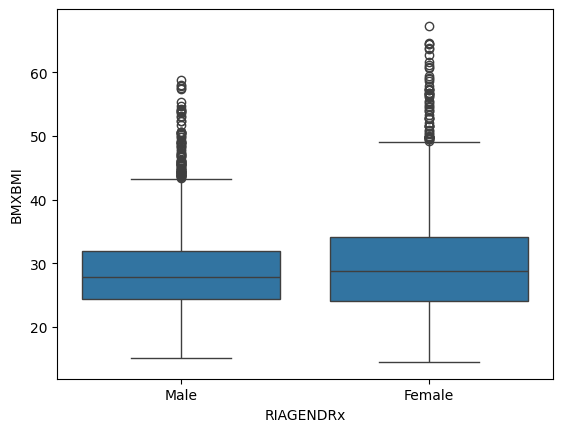

In [19]:
sns.boxplot(x="RIAGENDRx", y="BMXBMI", data=da);

Next we calculate the standard errors of the mean for females and for males:

In [20]:
sem_female = ta.loc["Female", ("BMXBMI", "std")] / np.sqrt(ta.loc["Female", ("BMXBMI", "size")])
sem_male = ta.loc["Male", ("BMXBMI", "std")] / np.sqrt(ta.loc["Male", ("BMXBMI", "size")])
(sem_female, sem_male)

(np.float64(0.14212522940758335), np.float64(0.11903715722332033))

The standard errors above indicate that when estimating the population mean BMI values for females and for males, the female estimate will be slightly less precise.  This reduced precision is largely due to the greater internal variability of the female BMI values.

In [21]:
sem_diff = np.sqrt(sem_female**2 + sem_male**2)
sem_diff

np.float64(0.18538992862064455)

The difference below is the point estimate of interest:

In [22]:
di = ta.loc["Female", ("BMXBMI", "mean")] - ta.loc["Male", ("BMXBMI", "mean")]

Based on the confidence interval below, any value between 0.8 and 1.53 could plausibly represent the difference between female and male BMI means.

In [23]:
lcb = di - 1.96 * sem_diff
ucb = di + 1.96 * sem_diff
(lcb, ucb)

(np.float64(0.798509280230502), np.float64(1.5252378004234286))